In [11]:
!pip install scikit-learn tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [14]:
# Mount Google Drive (if dataset is stored there)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Set dataset paths
hr_path = "/content/drive/MyDrive/SuperResolution/HR"
lr_path = "/content/drive/MyDrive/SuperResolution/LR"

In [16]:
# Function to load images
def load_images(hr_path, lr_path):
    hr_images, lr_images = [], []

    for i in range(1, 101):  # Assuming 100 images
        hr_file = os.path.join(hr_path, f'HR{i:03d}.jpg')
        lr_file = os.path.join(lr_path, f'LR{i:03d}.jpg')

        if os.path.exists(hr_file) and os.path.exists(lr_file):
            hr_img = img_to_array(load_img(hr_file, target_size=(256, 256))) / 255.0
            lr_img = img_to_array(load_img(lr_file, target_size=(64, 64))) / 255.0

            hr_images.append(hr_img)
            lr_images.append(lr_img)

    return np.array(hr_images), np.array(lr_images)

In [17]:
# Load dataset
hr_images, lr_images = load_images(hr_path, lr_path)

In [18]:
# Split dataset
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.2, random_state=42)

In [19]:
# Function to build the generator
def residual_block(x):
    res = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    res = layers.Conv2D(64, kernel_size=3, padding='same')(res)
    return layers.Add()([x, res])

def build_generator():
    inputs = layers.Input(shape=(64, 64, 3))

    x = layers.Conv2D(64, kernel_size=9, padding='same', activation='relu')(inputs)
    for _ in range(16):
        x = residual_block(x)
    x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)

    return models.Model(inputs, outputs, name='Generator')

In [20]:
# Function to build the discriminator
def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs, name='Discriminator')

In [21]:
# VGG-based perceptual loss
def build_vgg():
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    model.trainable = False
    return model

In [22]:
# Build models
generator = build_generator()
discriminator = build_discriminator()
vgg = build_vgg()

def perceptual_loss(y_true, y_pred):
    y_true_vgg = vgg(y_true)
    y_pred_vgg = vgg(y_pred)
    return MeanSquaredError()(y_true_vgg, y_pred_vgg)

def build_srgan(generator, discriminator):
    discriminator.trainable = False
    inputs = layers.Input(shape=(64, 64, 3))
    gen_output = generator(inputs)
    disc_output = discriminator(gen_output)
    return models.Model(inputs, [gen_output, disc_output], name='SRGAN')

srgan = build_srgan(generator, discriminator)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
# Compile models
discriminator.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
srgan.compile(loss=[perceptual_loss, BinaryCrossentropy()], loss_weights=[1, 1e-3], optimizer=Adam(learning_rate=1e-4))


In [35]:
# Training loop
batch_size = 8
epochs = 50
d_losses, g_losses = [], []

for epoch in range(epochs):
    epoch_d_loss, epoch_g_loss = [], []

    for i in range(0, len(lr_train), batch_size):
        lr_batch = lr_train[i:i+batch_size]
        hr_batch = hr_train[i:i+batch_size]

        fake_hr = generator.predict(lr_batch)
        real_labels, fake_labels = np.ones((batch_size, 1)), np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(hr_batch, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_hr, fake_labels)
        d_loss = d_loss_real[0] + d_loss_fake[0]
        g_loss = srgan.train_on_batch(lr_batch, [hr_batch, real_labels])

        epoch_d_loss.append(d_loss)
        epoch_g_loss.append(g_loss[0])

    d_losses.append(np.mean(epoch_d_loss))
    g_losses.append(np.mean(epoch_g_loss))
    print(f'Epoch {epoch+1}/{epochs} | D Loss: {d_losses[-1]:.4f} | G Loss: {g_losses[-1]:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/50 | D Loss: 1.3802 | G Loss: 0.0293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Epoch 2/50 | D Loss: 1.3802 | G Loss: 0.0292
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Avg PSNR: 7.93 dB, Avg SSIM: 0.0302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


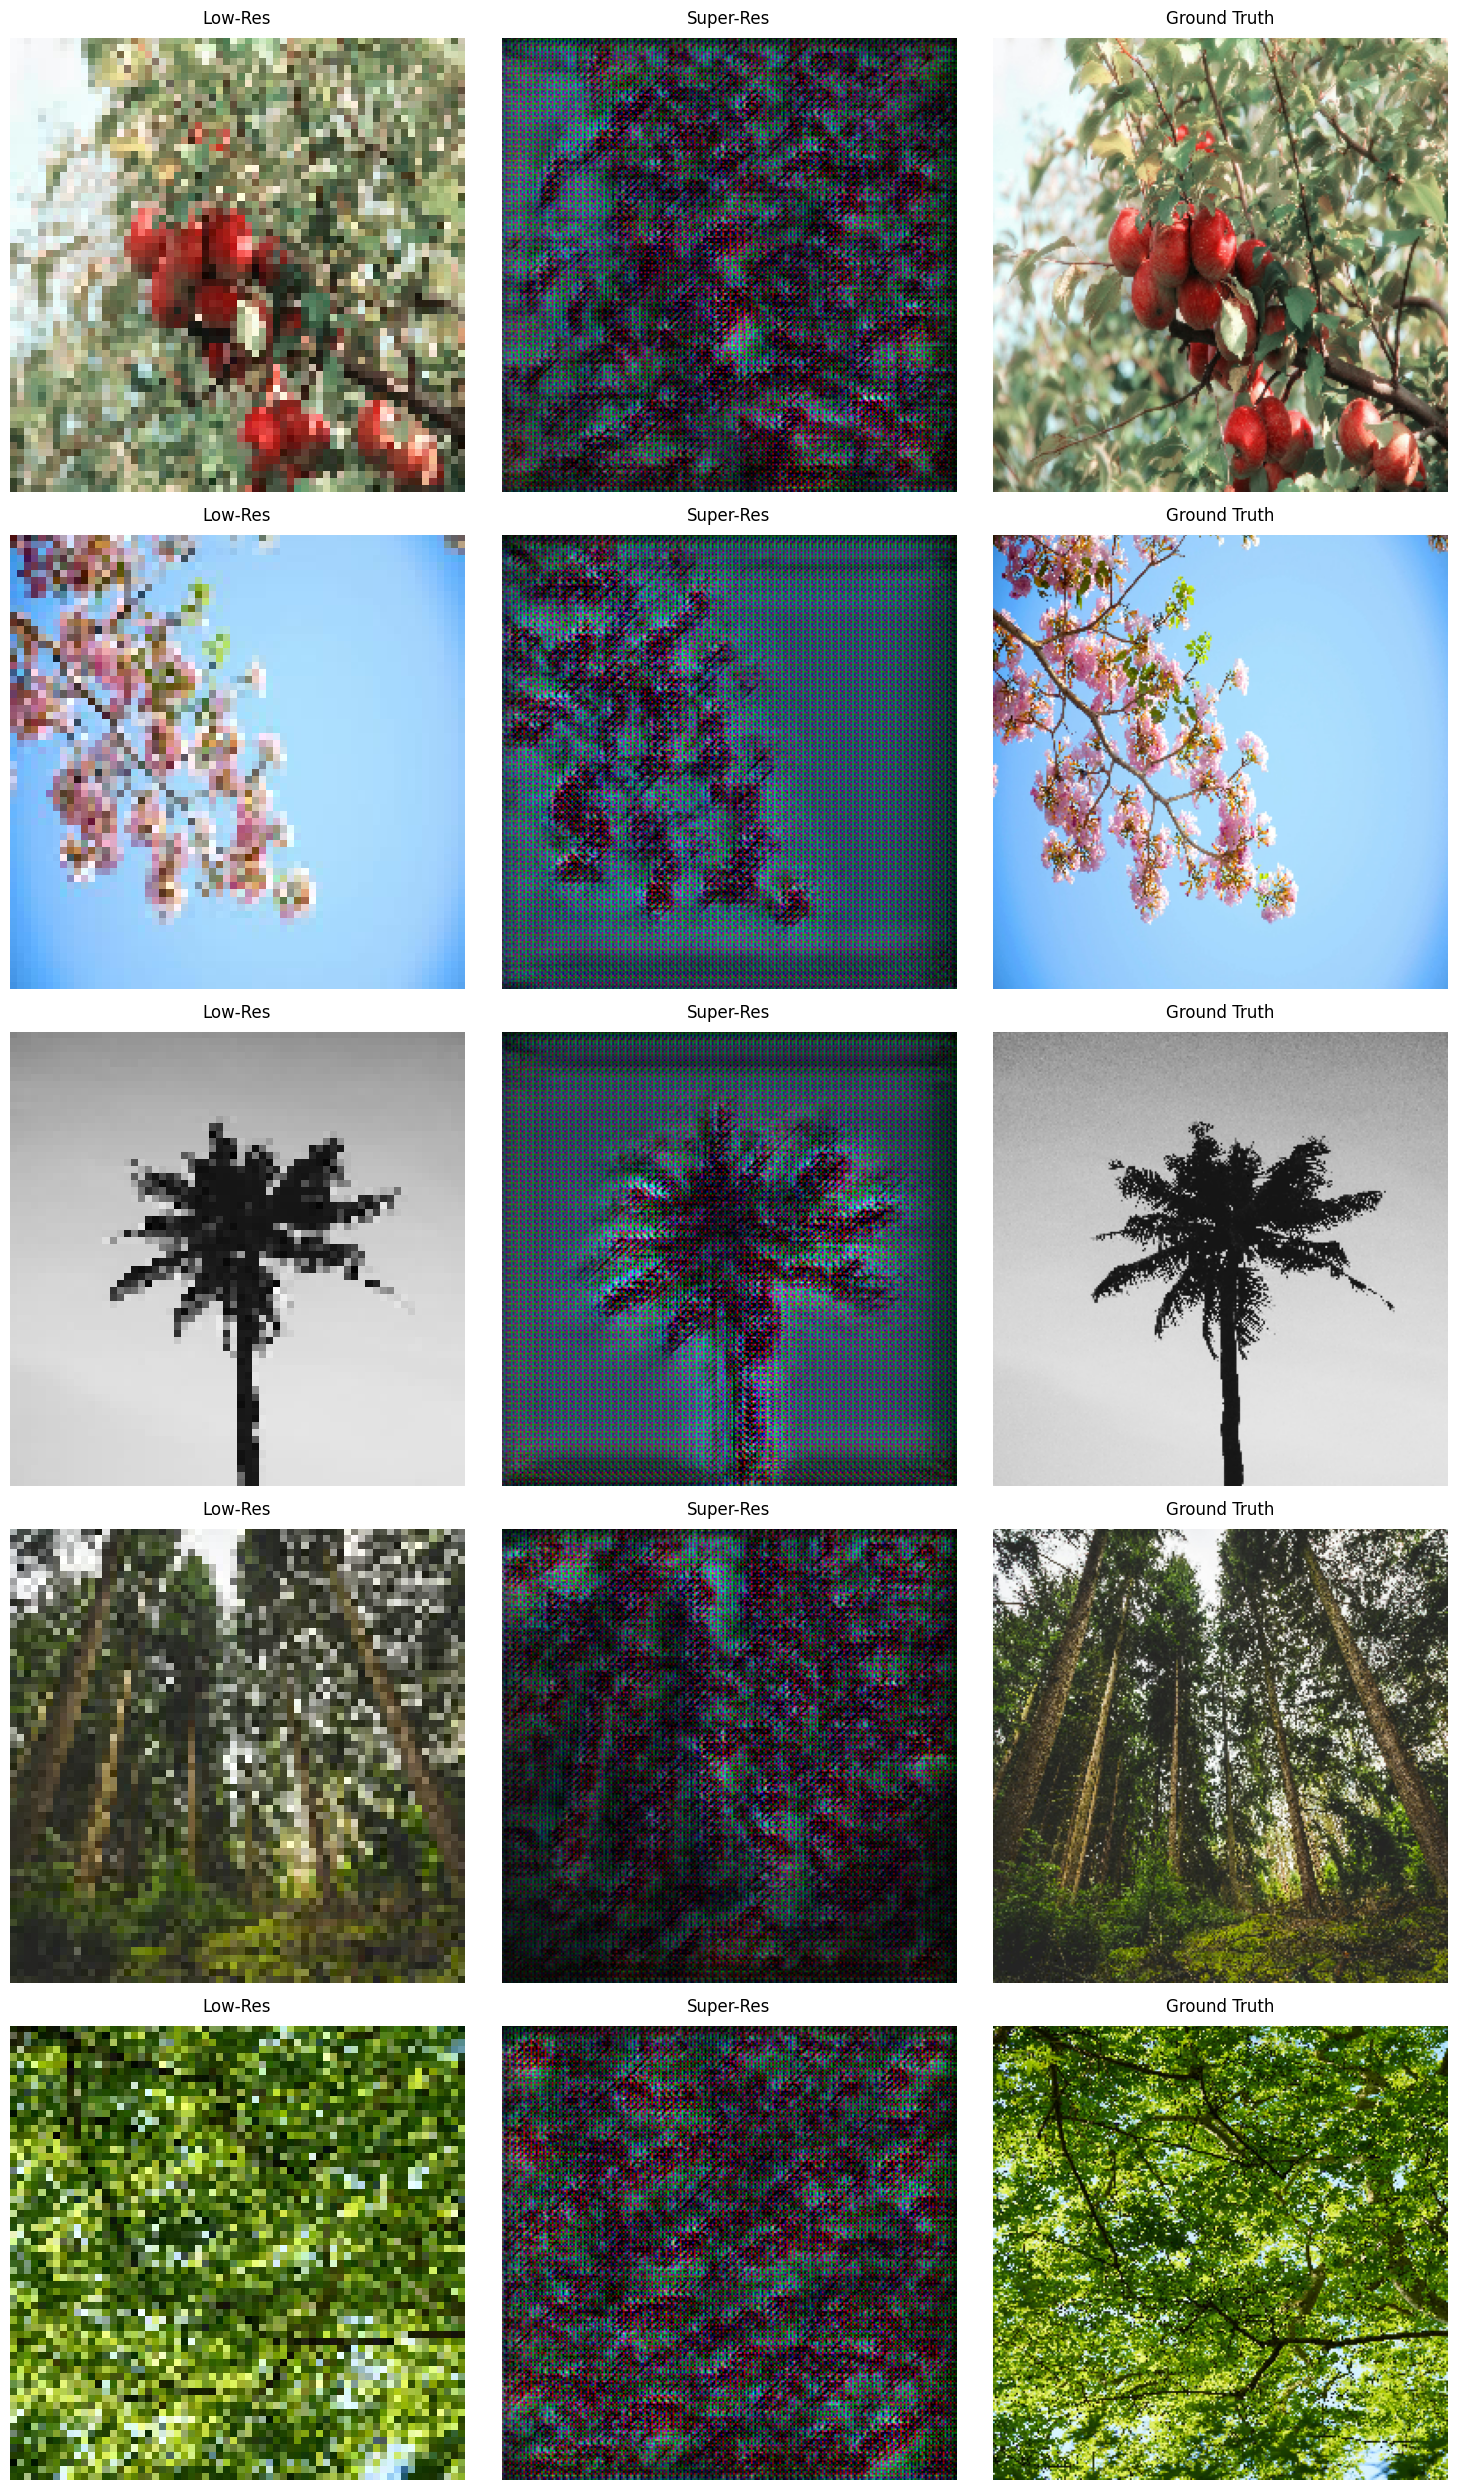

In [42]:
# Evaluate Model (this part remains the same)
def evaluate_model(generator, lr_test, hr_test):
    psnr_values, ssim_values = [], []
    for i in range(len(lr_test)):
        sr_img = generator.predict(np.expand_dims(lr_test[i], axis=0))[0]
        sr_img, hr_img = np.clip(sr_img * 255, 0, 255).astype(np.uint8), np.clip(hr_test[i] * 255, 0, 255).astype(np.uint8)
        psnr_values.append(psnr(hr_img, sr_img))
        ssim_values.append(ssim(hr_img, sr_img, multichannel=True, win_size=3))
    print(f'Avg PSNR: {np.mean(psnr_values):.2f} dB, Avg SSIM: {np.mean(ssim_values):.4f}')
evaluate_model(generator, lr_test, hr_test)


# Display multiple images
num_images_to_display = 5  # Change this to the desired number of images

fig, axes = plt.subplots(num_images_to_display, 3, figsize=(15, num_images_to_display * 5))

for i in range(num_images_to_display):
    lr_img = lr_test[i]
    sr_img = generator.predict(np.expand_dims(lr_img, axis=0))[0]
    hr_img = hr_test[i]

    sr_img = np.clip(sr_img * 255, 0, 255).astype(np.uint8)
    hr_img = np.clip(hr_img * 255, 0, 255).astype(np.uint8)
    lr_img = np.clip(lr_img * 255, 0, 255).astype(np.uint8)

    axes[i, 0].imshow(lr_img)
    axes[i, 0].set_title("Low-Res", fontsize=12, pad=10)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sr_img)
    axes[i, 1].set_title("Super-Res", fontsize=12, pad=10)
    axes[i, 1].axis("off")

    axes[i, 2].imshow(hr_img)
    axes[i, 2].set_title("Ground Truth", fontsize=12, pad=10)
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()